In [179]:
import pyopenms
import matplotlib.pyplot as plt
from pyopenms.plotting import plot_spectrum
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



In [280]:
file_path = '../DATASET/wwtp3_hit_smiles_std.mgf'
half_150_test = '../DATASET/half_150_test.mgf'
half_150_train = '../DATASET/half_150_train.mgf'
exp = pyopenms.MSExperiment()
half_150_test_exp = pyopenms.MSExperiment()
half_150_train_exp = pyopenms.MSExperiment()
pyopenms.FileHandler().loadExperiment(file_path, exp)
pyopenms.FileHandler().loadExperiment(half_150_test, half_150_test_exp)
pyopenms.FileHandler().loadExperiment(half_150_train, half_150_train_exp)

Comparison of two spectra

In [334]:
def plot_two_spectra_advanced(
    spectrum1,
    spectrum2,
    label1="Spectrum 1",
    label2="Spectrum 2",
    title="Spectrum Comparison with Top 3 Peaks Labeled",
    smiles='',
    anomy='',
    name='',
    is_pfas=False,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 7))  # 加大圖形尺寸
    
    peaks1 = spectrum1.get_peaks()
    peaks2 = spectrum2.get_peaks()
    
    # Normalize intensities
    # max_intensity = max(max(peaks1[1]), max(peaks2[1]))
    norm_peaks1 = peaks1[1] / max(peaks1[1])
    norm_peaks2 = peaks2[1] / max(peaks2[1])

    # Plot spectra
    stem1 = ax1.stem(peaks1[0], norm_peaks1, markerfmt=' ', basefmt=' ', linefmt='b-', label=label1)
    stem2 = ax1.stem(peaks2[0], norm_peaks2, markerfmt=' ', basefmt=' ', linefmt='r-', label=label2)
    
    # 找出每個spectrum強度前三高的peaks
    def get_top3_peaks(mz_array, intensity_array):
        peaks = list(zip(mz_array, intensity_array))
        return sorted(peaks, key=lambda x: x[1], reverse=True)[:4]
    
    top3_1 = get_top3_peaks(peaks1[0], norm_peaks1)
    top3_2 = get_top3_peaks(peaks2[0], norm_peaks2)
    
    # 改進的標註位置計算
    def get_annotation_positions(peaks, index, pos):
        """根據peak位置計算合適的標註位置"""
        positions = []
        for i, (mz, intensity) in enumerate(peaks):
            # 交替標註在左側和右側
            if (i + pos) % 2 == 0:
                xytext = (-60 if index == 0 else -80, 40 + i*5)
                ha = 'right'
            else:
                xytext = (60 if index == 0 else 80, 40 + i*5)
                ha = 'left'
            positions.append((xytext, ha))
        return positions
    
    # 獲取標註位置
    pos1 = get_annotation_positions(top3_1, 0, 1)
    pos2 = get_annotation_positions(top3_2, 1, 0)
    
    # 標註spectrum1的前三高peaks (藍色)
    for (mz, intensity), (xytext, ha) in zip(top3_1, pos1):
        ax1.annotate(f"{mz:.4f}", 
                    xy=(mz, intensity),
                    xytext=xytext,
                    textcoords='offset points',
                    color='blue',
                    ha=ha,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', lw=1, alpha=0.8),
                    arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3,rad=-0.0"))
    
    # 標註spectrum2的前三高peaks (紅色)
    for (mz, intensity), (xytext, ha) in zip(top3_2, pos2):
        ax1.annotate(f"{mz:.4f}", 
                    xy=(mz, intensity),
                    xytext=xytext,
                    textcoords='offset points',
                    color='red',
                    ha=ha,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1, alpha=0.8),
                    arrowprops=dict(arrowstyle="->", color='red', connectionstyle="arc3,rad=-0.0"))
    
    # 圖形設置
    ax1.set_ylim(0, 1.3)  # 增加更多空間
    ax1.set_ylabel("Normalized Intensity")
    ax1.set_xlabel("m/z")
    ax1.set_title(title)
    ax1.legend(loc='upper right')

    # 添加網格線提高可讀性
    # ax1.grid(True, linestyle='--', alpha=0.6)

    # 生成分子結構圖
    def draw_molecule(smiles, size=(300,300)):
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        d2d = Draw.MolDraw2DCairo(size[0], size[1])
        d2d.DrawMolecule(mol)
        d2d.FinishDrawing()
        return Image.open(BytesIO(d2d.GetDrawingText()))
    
    # 選擇圖中空白區域放置分子結構 (右上角)
    x_pos = 0.22  # x軸位置 (0-1比例)
    y_pos = 0.8  # y軸位置 (0-1比例)
    
    # 繪製分子結構 (PFPrA: Perfluoropropionic acid)
    img = draw_molecule(smiles, size=(300, 300))
    
    # 將分子結構嵌入到譜圖中
    imagebox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imagebox, (x_pos, y_pos),
                       xycoords='axes fraction',
                       box_alignment=(0.5,0.5),
                       frameon=False)
    ax1.add_artist(ab)
    
    # 添加分子名稱標註
    ax1.text(x_pos, y_pos-0.2, f"{anomy}\n({name})",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12,
           bbox=dict(facecolor='white', alpha=0.0, edgecolor='gray', boxstyle='round,pad=0.2'))

    # 添加可能的碎片化註釋
    ax1.text(0.55, 0.5, "Annotated as PFAS by DeePFAS\n(the spectrum in WWTP3):",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'black'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))

    ax1.text(0.55, 0.45, "YES" if is_pfas else "NO",
           transform=ax1.transAxes,
           ha='center', va='center', fontsize=12, fontdict={'color': 'green' if is_pfas else 'red'},
           bbox=dict(facecolor='white', alpha=0, edgecolor='gray', boxstyle='round,pad=0.2'))
    plt.tight_layout()
    plt.show()


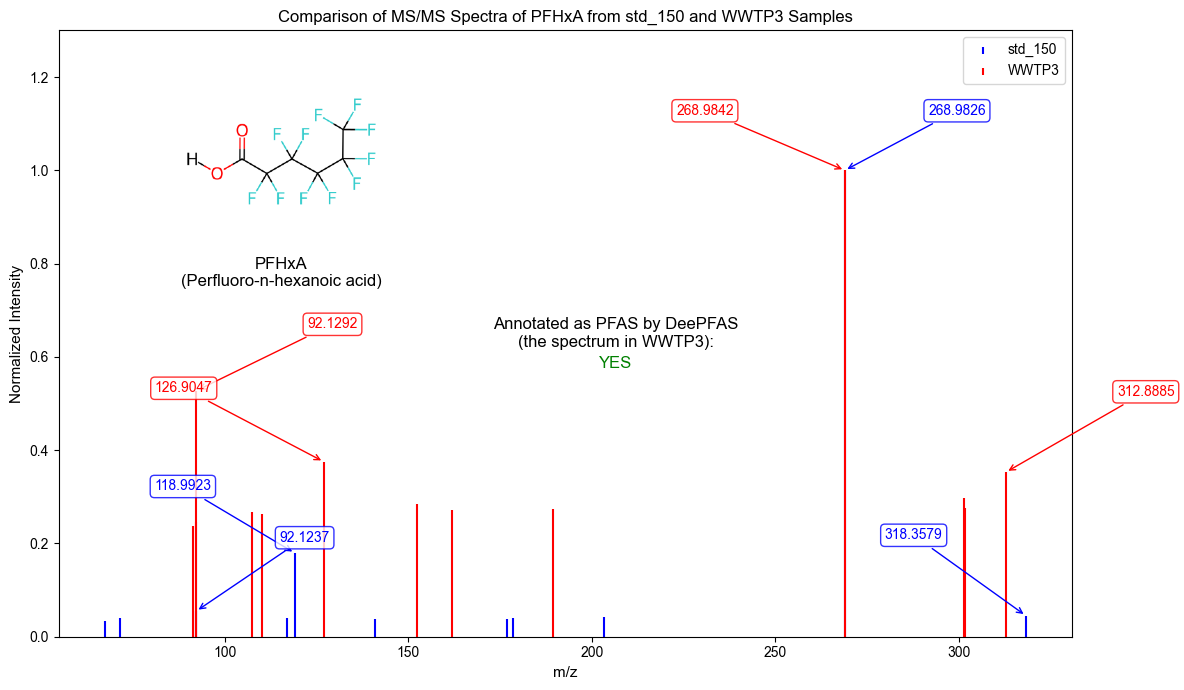

In [336]:

plot_two_spectra_advanced(
    half_150_train_exp[19],
    exp[125],
    "std_150",
    "WWTP3",
    "Comparison of MS/MS Spectra of PFHxA from std_150 and WWTP3 Samples", 
    "O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F",
    "PFHxA",
    "Perfluoro-n-hexanoic acid",
    True
    )
